In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/Users/tommylees/github/ml_drought


In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_dir = Path('data/zip_data')
data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')

assert data_dir.exists()

# assess model performances

Looking at how the different algorithms compared on the ERA5 grid

In [8]:
from src.analysis import annual_scores

[f.name for f in (data_dir / 'models' / 'one_month_forecast').iterdir()]

['ealstm',
 'ealstm_ERA5_128',
 'ealstm_VCI',
 'linear_network',
 'linear_regression',
 'previous_month',
 'previous_month_VCI',
 'rnn',
 'rnn_VCI']

In [9]:
# load the monthly scores dictionary
monthly_scores = annual_scores(
    data_path=data_dir,
    models=['previous_month', 'ealstm', 'ealstm_ERA5_128', 'rnn'],
    metrics=['rmse', 'r2'],
    verbose=False,
    to_dataframe=True
)

Text(0, 0.5, 'VCI RMSE')

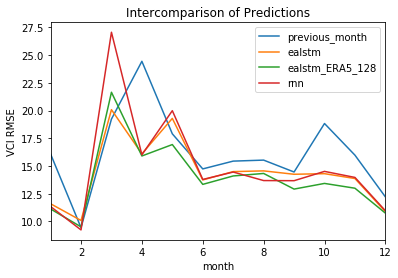

In [17]:
ax = (
    monthly_scores
    .where(monthly_scores.metric == 'rmse')
    .drop(columns=['year', 'metric'])
).plot('month')

ax.set_title('Intercomparison of Predictions')
ax.set_ylabel('VCI RMSE')

# view the spatial predictions any patterns?

In [19]:
monthly_scores.head()

,month,year,previous_month,ealstm,ealstm_ERA5_128,rnn,metric
0,1.0,2018.0,16.086050,11.596791,11.124692,11.345142,rmse
1,2.0,2018.0,9.440623,10.087028,9.512637,9.235682,rmse
2,3.0,2018.0,19.234719,20.086194,21.655906,27.069588,rmse
3,4.0,2018.0,24.447388,16.096951,15.906613,16.013875,rmse
4,5.0,2018.0,17.905360,19.297321,16.936694,19.993250,rmse


In [22]:
from src.analysis import read_pred_data, read_true_data

In [48]:
ealstm_256 = read_pred_data('ealstm', data_dir=data_dir)[0]
ealstm_128 = read_pred_data('ealstm_ERA5_128', data_dir=data_dir)[0]
previous_month = read_pred_data('previous_month', data_dir=data_dir)[0]
rnn = read_pred_data('rnn', data_dir=data_dir)[0]

obs = read_true_data(data_dir=data_dir)

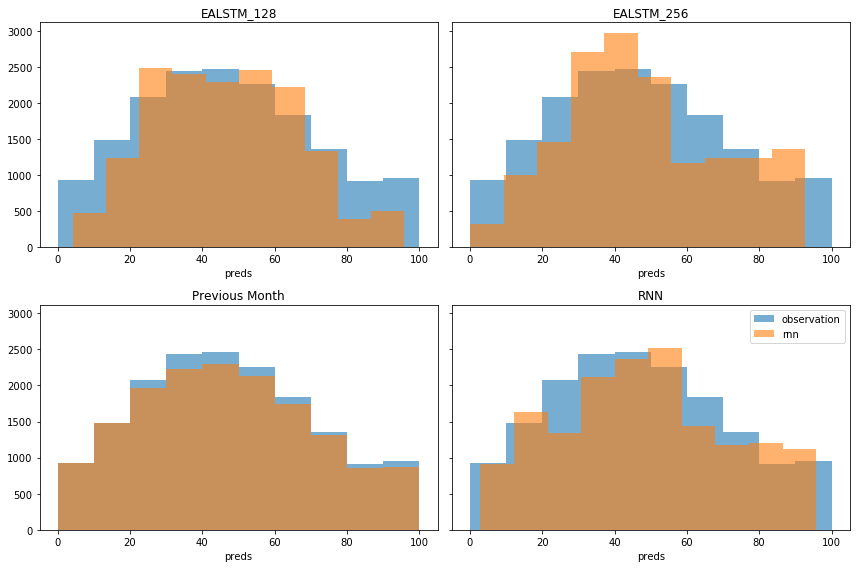

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharey=True)
obs.plot(alpha=0.6, label='observation', ax=axs[0,0]);
ealstm_128.preds.plot(alpha=0.6, label='ealstm_128', ax=axs[0,0]);
axs[0,0].set_title('EALSTM_128')

obs.plot(alpha=0.6, label='observation', ax=axs[0,1]);
ealstm_256.preds.plot(alpha=0.6, label='ealstm_256', ax=axs[0,1]);
axs[0,1].set_title('EALSTM_256')

obs.plot(alpha=0.6, label='observation', ax=axs[1,0]);
previous_month.preds.plot(alpha=0.6, label='previous_month', ax=axs[1,0]);
axs[1,0].set_title('Previous Month')

obs.plot(alpha=0.6, label='observation', ax=axs[1,1]);
rnn.preds.plot(alpha=0.6, label='rnn', ax=axs[1,1]);
axs[1,1].set_title('RNN')
plt.legend()

plt.tight_layout()

# spatial predictions

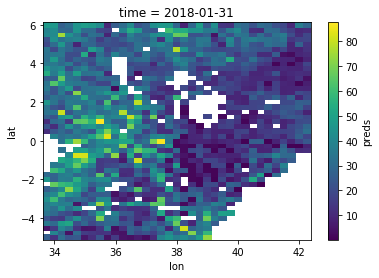

In [57]:
ealstm_256.isel(time=0).preds.plot()

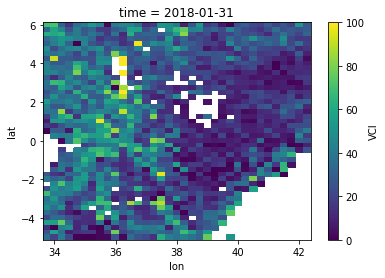

In [58]:
obs.isel(time=0).plot()

# analysis by region

In [62]:
from src.analysis import AdministrativeRegionAnalysis
# from src.analysis import KenyaGroupbyRegion

In [64]:
warnings.filterwarnings('ignore')

analyzer = AdministrativeRegionAnalysis(data_dir=data_dir)
analyzer.analyze()

Initialised the Region Analysis for experiment: one_month_forecast
Models: ['ealstm', 'ealstm_ERA5_128', 'ealstm_VCI', 'linear_network', 'linear_regression', 'previous_month', 'previous_month_VCI', 'rnn', 'rnn_VCI']
Regions: ['district_l2_kenya.nc', 'division_l3_kenya.nc', 'location_l4_kenya.nc', 'province_l1_kenya.nc', 'region_kenya.nc']
Region Type: administrative_boundaries
* Analyzing for district_l2_kenya *

** Analyzing for ealstm-district_l2_kenya **


AssertionError: Expect the lat/lon shapes to match in all input DataArrays(45, 35) == (45, 35) == (311, 244). are you sure these have all been run with the same experiment and the same reference_nc_file to regrid onto same reference_grid

Initialised the Region Analysis for experiment: one_month_forecast
Models: ['ealstm', 'ealstm_ERA5_128', 'ealstm_VCI', 'linear_network', 'linear_regression', 'previous_month', 'previous_month_VCI', 'rnn', 'rnn_VCI']
Regions: ['district_l2_kenya.nc', 'division_l3_kenya.nc', 'location_l4_kenya.nc', 'province_l1_kenya.nc']
Region Type: administrative_boundaries
* Analyzing for district_l2_kenya *

** Analyzing for ealstm-district_l2_kenya **


AssertionError: Expect the lat/lon shapes to match in all input DataArrays(45, 35) == (45, 35) == (311, 244). are you sure these have all been run with the same experiment and the same reference_nc_file to regrid onto same reference_grid

In [19]:
# extract a GeoDataFrame that we can plot
region_plotter = analyzer.create_model_performance_by_region_geodataframe()
metric_gdf = region_plotter.gdf
metric_gdf.head()

The RegionGeoPlotter requires `geopandas` to be installed.
GroupbyRegion requires geopandas to be installed
Reading file: KEN_admin2_2002_DEPHA.shp
Reading file: Ken_Districts.shp
Reading file: Ken_Divisions.shp
Reading file: Kenya wards.shp
Reading file: Ken_Locations.shp
Reading file: Ken_Sublocations.shp
* Read shapefiles and stored in `RegionGeoPlotter.region_gdfs` *
* Assigned the complete GeoDataFrame to `RegionGeoPlotter.gdf`


,model,admin_level_name,region_name,rmse,mae,r2,DISTNAME,geometry
0,ealstm,district_l2_kenya,NAIROBI,13.034867,9.907392,-0.674941,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
1,previous_month,district_l2_kenya,NAIROBI,11.051595,9.795107,-0.204027,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
2,ealstm,district_l2_kenya,SAMBURU,6.926626,5.606387,0.573924,SAMBURU,"POLYGON ((36.75165473150634 2.519848937106019,..."
3,previous_month,district_l2_kenya,SAMBURU,7.961759,5.947568,0.437061,SAMBURU,"POLYGON ((36.75165473150634 2.519848937106019,..."
4,ealstm,district_l2_kenya,TRANS MARA,9.777603,7.809506,-0.072351,TRANS MARA,POLYGON ((35.15025473150634 -0.959251062893981...


### How does the error vary in each region?

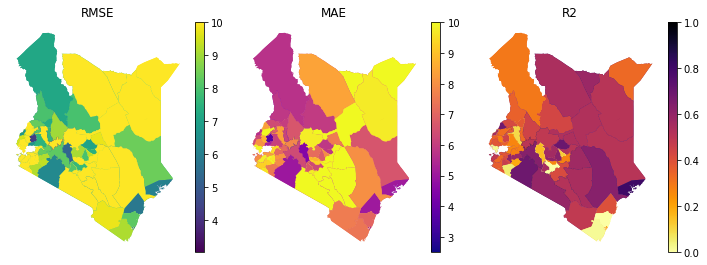

In [20]:
region_plotter.plot_all_regional_error_metrics(metric_gdf);

### How do we do when we compare to the [Adede et al 2019](https://www.mdpi.com/2072-4292/11/9/1099/htm) paper?

The paper presents $R^2$ results for four districts:
- Mandera - 0.71
- Marsabit - 0.77
- Turkana - 0.83
- Wajir - 0.71

These are defined as Arid and Semi Arid Lands (ASAL) districts. They are actively monitored by the National Drought Management Authority.

In [21]:
# join true/preds into a GeoDataFrame
gdf = region_plotter.merge_all_model_performances_gdfs(analyzer.df)
gdf.head()

* Assigned the complete GeoDataFrame to `RegionGeoPlotter.gdf`


,admin_level_name,model,datetime,region_name,predicted_mean_value,true_mean_value,DISTNAME,geometry
0,district_l2_kenya,ealstm,2018-01-31,NAIROBI,27.561455,23.551954,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
1,district_l2_kenya,previous_month,2018-01-31,NAIROBI,32.159204,23.551954,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
2,district_l2_kenya,previous_month,2018-02-28,NAIROBI,23.551954,20.263123,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
3,district_l2_kenya,ealstm,2018-02-28,NAIROBI,29.441332,20.263123,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
4,district_l2_kenya,previous_month,2018-03-31,NAIROBI,20.263125,29.301306,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
